# 1-7. 미니 프로젝트 : 가위바위보 분류기를 만들자

## 데이터 준비

### 데이터 만들기
노트북 카메라를 이용하여 가위, 바위, 보 이미지 각 100장을 만들어본다. 구글의 teachable machine 사이트에서 쉽게 데이터를 만들 수 있다.

[https://teachablemachine.withgoogle.com/](https://teachablemachine.withgoogle.com/)

- 여러 각도에서 찍기
- 여러 크기로 찍기
- 여러 명이 찍기

좋은 데이터가 좋은 결과를 낳는다.

teachable machine을 통해서 이미지를 저장하면 이미지는 224x224 크기로 되어 있다.

### 데이터 불러오기 + Resize 하기
가위, 바위, 보 이미지를 28x28로 만들어야 한다. 이를 위해 `PIL` 라이브러리를 사용한다.

In [1]:
from PIL import Image
import os, glob

In [2]:
import os

total_image = 0
RESIZE = 28

# 이미지를 리사이즈 해주는 함수
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    global total_image 
    total_image += len(images)
    
    print(f"{len(images)} images will be resized.")
    
    # resize all images to 28x28
    target_size=(RESIZE, RESIZE) # 28x28 size
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(f"{len(images)} images have been resized.\n")


In [3]:
data_dir = os.path.dirname(os.path.abspath('__file__')) # 현재 위치
data_dir += r'/data/' # 데이터 폴더 위치
print(data_dir)

/aiffel/data/


In [4]:
train_path = data_dir + r'train/'
scissor_train_path = train_path + r'scissors/'
rock_train_path = train_path + r'rock/'
paper_train_path = train_path + r'paper/'

train_paths = [scissor_train_path, rock_train_path, paper_train_path]
print(train_paths)

['/aiffel/data/train/scissors/', '/aiffel/data/train/rock/', '/aiffel/data/train/paper/']


In [5]:
for path in train_paths:
    resize_images(path)

print(total_image)

994 images will be resized.
994 images have been resized.

1105 images will be resized.
1105 images have been resized.

1108 images will be resized.
1108 images have been resized.

3207


### 가위, 바위, 보 데이터를 읽는 `load_data()` 함수 만들기

`load_data()` 함수는 입력으로 이미지가 있는 폴더 위치를 받는다. 여기서는 `rock_scissor_paper` 폴더 위치를 적어주면 된다.

In [6]:
import numpy as np

def load_data(img_path, number_of_data=300): 
    """    
    parameters:
        img_path: The directory path of the rock_scissor_paper
        number_of_data: The total nubmer of all images. Default value is 300.
    return:
        image data, label data
    """
    # scissors: 0, rock: 1, paper: 2
    img_size = RESIZE
    color = 3
    
    # image data
    imgs = np.zeros(number_of_data * img_size * img_size * color, 
                    dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/scissors/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0 # 가위 : 0
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1 # 바위 : 1
        idx = idx + 1
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2 # 보 : 2
        idx = idx + 1
        
    print(f"이미지 개수는 {idx} 입니다.")
    return imgs, labels

In [7]:
(X, y) = load_data(train_path, number_of_data=3207)

이미지 개수는 3207 입니다.


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# validation 추가
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, stratify=y_train, 
                                                  random_state=1)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1923, 28, 28, 3)
y_train shape: (1923,)
X_val shape: (642, 28, 28, 3)
y_val shape: (642,)
X_test shape: (642, 28, 28, 3)
y_test shape: (642,)


In [9]:
# 정규화
X_train = X_train / 255.0   # 입력은 0~1 사이의 값으로 정규화

라벨:  1


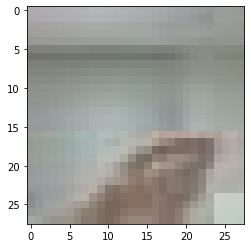

In [10]:
import matplotlib.pyplot as plt

# 이미지 확인
plt.imshow(X_train[0])
print('라벨: ', y_train[0])

## 딥러닝 네트워크 설계하기

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(RESIZE, RESIZE, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  10


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 128)         0

## 딥러닝 네트워크 학습시키기

In [13]:
# x_train 학습 데이터로 딥러닝 네트워크 학습
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val)) # epochs은 반복 횟수

Epoch 1/30
61/61 [==============================] - 9s 76ms/step - loss: 1.0910 - accuracy: 0.3652 - val_loss: 38.3454 - val_accuracy: 0.4128
Epoch 2/30
61/61 [==============================] - 0s 6ms/step - loss: 1.0197 - accuracy: 0.4815 - val_loss: 68.3951 - val_accuracy: 0.5234
Epoch 3/30
61/61 [==============================] - 0s 6ms/step - loss: 0.8597 - accuracy: 0.6012 - val_loss: 58.9558 - val_accuracy: 0.6137
Epoch 4/30
61/61 [==============================] - 0s 5ms/step - loss: 0.7565 - accuracy: 0.6466 - val_loss: 83.8829 - val_accuracy: 0.6402
Epoch 5/30
61/61 [==============================] - 0s 5ms/step - loss: 0.5344 - accuracy: 0.7667 - val_loss: 220.0453 - val_accuracy: 0.5125
Epoch 6/30
61/61 [==============================] - 0s 5ms/step - loss: 0.5509 - accuracy: 0.7556 - val_loss: 87.0177 - val_accuracy: 0.7040
Epoch 7/30
61/61 [==============================] - 0s 5ms/step - loss: 0.3403 - accuracy: 0.8670 - val_loss: 84.0164 - val_accuracy: 0.6994
Epoch 8/30


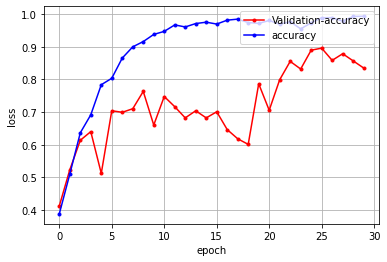

In [14]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

x_len = np.arange(len(accuracy))
plt.plot(x_len, val_accuracy, marker='.', c='red', label="Validation-accuracy")
plt.plot(x_len, accuracy, marker='.', c='blue', label="accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

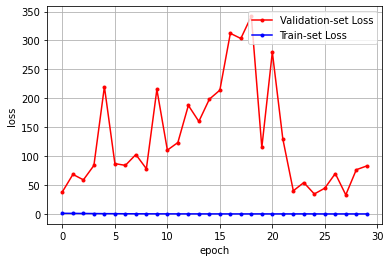

In [15]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## test 데이터로 테스트

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

21/21 - 0s - loss: 92.1968 - accuracy: 0.8427
test_loss: 92.19679260253906
test_accuracy: 0.8426791429519653


In [17]:
predicted_result = model.predict(X_test) # model이 추론한 확률값
predicted_labels = np.argmax(predicted_result, axis=1) # 확률의 최대값이 예측하는 숫자를 뜻한다

idx = 0
print(f"models.predict() 결과: {predicted_result[idx]}\n")
print(f"model이 추론한 가장 가능성이 높은 결과 : ", predicted_labels[idx])
print(f"실제 데이터의 라벨 : ", y_test[idx])

models.predict() 결과: [0. 1. 0.]

model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


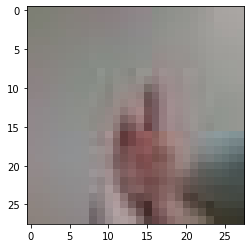

In [18]:
# 실제 이미지 출력
plt.imshow(X_test[idx], cmap=plt.cm.binary)
plt.show()

## 새로운 데이터로 테스트

In [19]:
test_path = data_dir + r'/test/'
scissor_test_path = test_path + r'/scissors'
rock_test_path = test_path + r'/rock'
paper_test_path = test_path + r'/paper'

test_paths = [scissor_test_path, rock_test_path, paper_test_path]

for path in test_paths:
    resize_images(path)

(x_test, y_test)=load_data(test_path)
x_test_norm = x_test / 255.0

print(x_test_norm.shape)

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

100 images will be resized.
100 images have been resized.

100 images will be resized.
100 images have been resized.

100 images will be resized.
100 images have been resized.

이미지 개수는 300 입니다.
(300, 28, 28, 3)
10/10 - 2s - loss: 7.4607 - accuracy: 0.5767
test_loss: 7.460700511932373
test_accuracy: 0.5766666531562805


## 더 좋은 네트워크 만들어보기
- [x] 더 많은 데이터 추가하기
- [x] Validation Set 만들기
- [ ] 하이퍼파라미터 변경
- [ ] 딥러닝 모델 바꾸기